# OpenAI-to-Z Challenge: Strict Geometric Filtering

This notebook implements the stricter geometric filtering and pattern recognition logic based on expert feedback. The goal is to isolate potential archaeological features by applying more rigorous constraints.

**Pipeline:**
1.  Load and preprocess the DTM data, including masking NoData values.
2.  Generate a hillshade and apply a high-pass filter.
3.  Detect lines using the Hough Transform.
4.  Apply a strict length filter (50-400m).
5.  Identify clusters of lines that are parallel or perpendicular and in close proximity.
6.  Visualize only the geometrically significant clusters.

## 1. Setup and Imports

In [1]:
import os
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

print("Libraries imported.")

Libraries imported.


## 2. Load and Preprocess DTM Data

In [2]:
dtm_raster_path = '/Users/shg/Projects/openai-a-z-challenge/data/raw/TAL_A01_2018/TAL_A01_2018_DTM/TAL01L0001C0002.grd'

try:
    with rasterio.open(dtm_raster_path) as src:
        dtm_data = src.read(1, masked=True)
        profile = src.profile
        pixel_resolution = profile['transform'][0]
        print(f"DTM file loaded. Shape: {dtm_data.shape}, Resolution: {pixel_resolution:.2f}m/pixel")
except Exception as e:
    print(f"Error loading DTM file: {e}")

DTM file loaded. Shape: (1001, 1001), Resolution: 1.00m/pixel


## 3. Generate and Filter Hillshade

In [3]:
def simple_hillshade(array, azimuth, altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = altitude*np.pi/180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos((azimuthrad - np.pi/2.) - aspect)
    return 255*(shaded + 1)/2

def high_pass_filter(image, kernel_size=21):
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    filtered = cv2.subtract(image, blurred)
    return filtered

try:
    dtm_filled = dtm_data.filled(dtm_data.mean())
    hillshade_data = simple_hillshade(dtm_filled, 315, 45)
    filtered_hillshade = high_pass_filter(hillshade_data)
    print("Hillshade generated and high-pass filter applied.")
except NameError:
    print("DTM data not loaded, skipping hillshade generation.")

Hillshade generated and high-pass filter applied.


## 4. Detect and Apply Strict Filters to Lines

In [4]:
def detect_lines(image_data):
    normalized_image = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    edges = cv2.Canny(normalized_image, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=30, maxLineGap=10)
    return lines, edges

def filter_lines_by_length(lines, resolution_m, min_len_m=50, max_len_m=400):
    if lines is None:
        return []
    filtered = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length_m = np.sqrt((x2 - x1)**2 + (y2 - y1)**2) * resolution_m
        if min_len_m <= length_m <= max_len_m:
            filtered.append(line)
    return filtered

def get_line_properties(line):
    x1, y1, x2, y2 = line[0]
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)
    return angle, midpoint

def find_geometric_clusters(lines, angle_tol=5, dist_tol=50):
    if not lines:
        return []
    
    props = [get_line_properties(l) for l in lines]
    num_lines = len(lines)
    related_mask = [False] * num_lines

    for i in range(num_lines):
        for j in range(i + 1, num_lines):
            angle1, mid1 = props[i]
            angle2, mid2 = props[j]

            dist = math.sqrt((mid1[0] - mid2[0])**2 + (mid1[1] - mid2[1])**2)
            if dist > dist_tol:
                continue

            angle_diff = abs(angle1 - angle2)
            is_parallel = angle_diff < angle_tol or abs(angle_diff - 180) < angle_tol
            is_perpendicular = abs(angle_diff - 90) < angle_tol or abs(angle_diff - 270) < angle_tol

            if is_parallel or is_perpendicular:
                related_mask[i] = True
                related_mask[j] = True
                
    return [lines[i] for i, related in enumerate(related_mask) if related]

try:
    initial_lines, detected_edges = detect_lines(filtered_hillshade)
    length_filtered = filter_lines_by_length(initial_lines, pixel_resolution)
    geometric_clusters = find_geometric_clusters(length_filtered)
    
    print(f"Initial lines: {len(initial_lines) if initial_lines is not None else 0}")
    print(f"After length filter (50-400m): {len(length_filtered)}")
    print(f"After geometric clustering: {len(geometric_clusters)}")
except NameError:
    print("Preprocessing steps failed, skipping analysis.")
    geometric_clusters = []

Initial lines: 1255
After length filter (50-400m): 434
After geometric clustering: 348


## 5. Visualize Final Geometric Patterns

Final visualization saved to /Users/shg/Projects/openai-a-z-challenge/strict_geometric_results.png


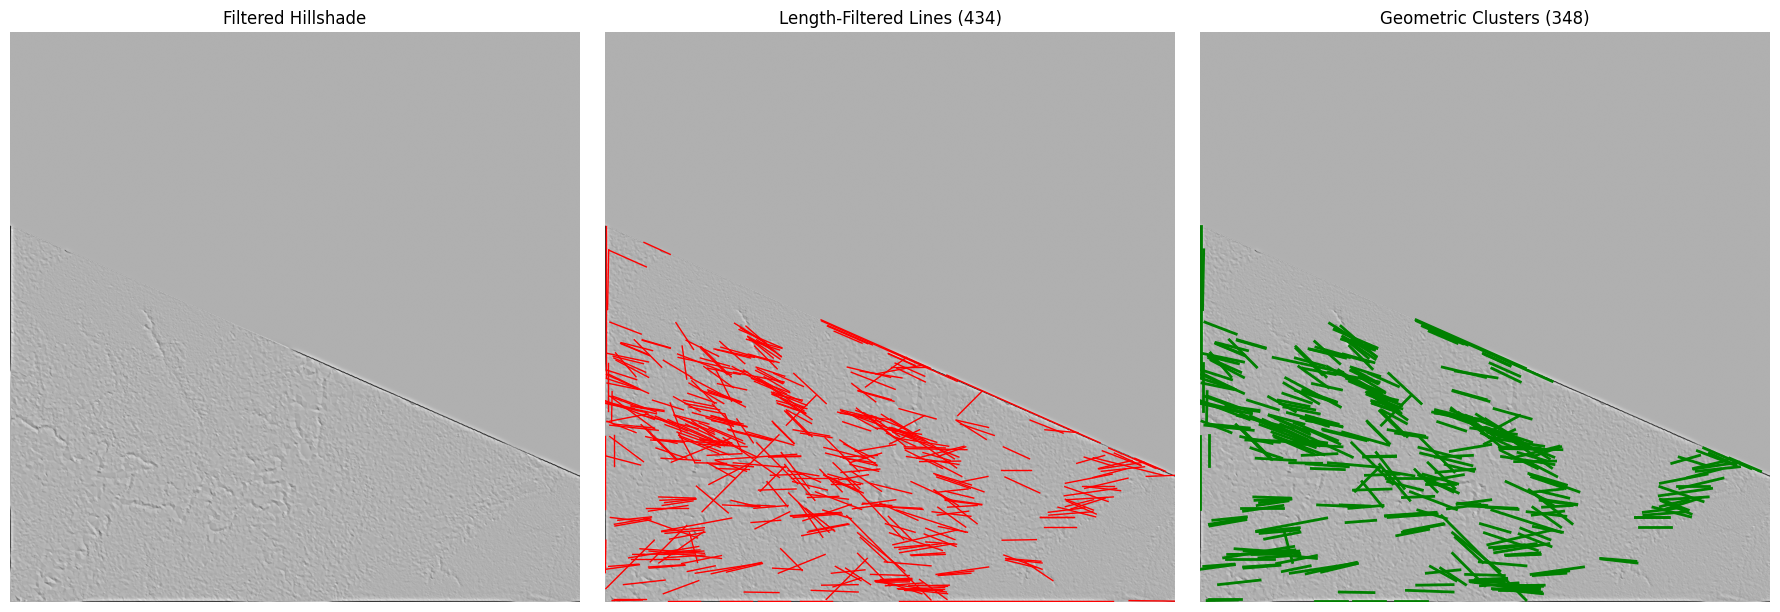

In [5]:
try:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

    # 1. Filtered Hillshade
    axes[0].imshow(filtered_hillshade, cmap='gray')
    axes[0].set_title('Filtered Hillshade')
    axes[0].axis('off')

    # 2. All Length-Filtered Lines
    axes[1].imshow(filtered_hillshade, cmap='gray')
    if length_filtered:
        for line in length_filtered:
            x1, y1, x2, y2 = line[0]
            axes[1].plot([x1, x2], [y1, y2], 'r-', linewidth=1)
    axes[1].set_title(f'Length-Filtered Lines ({len(length_filtered)})')
    axes[1].axis('off')

    # 3. Final Geometric Clusters
    axes[2].imshow(filtered_hillshade, cmap='gray')
    if geometric_clusters:
        for line in geometric_clusters:
            x1, y1, x2, y2 = line[0]
            axes[2].plot([x1, x2], [y1, y2], 'g-', linewidth=2)
    axes[2].set_title(f'Geometric Clusters ({len(geometric_clusters)})')
    axes[2].axis('off')

    plt.tight_layout()
    
    # Save the figure
    output_path = '/Users/shg/Projects/openai-a-z-challenge/strict_geometric_results.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Final visualization saved to {output_path}")
    
    plt.show()
except NameError as e:
    print(f"Could not generate visualization: {e}")